https://github.com/pytorch/tutorials/blob/master/beginner_source/dcgan_faces_tutorial.py
위의 주소는 pytorch dcgan 공식 튜토리얼 코드입니다.
위 코드나 아래 코드에 주석을 자유롭게 한글로 달아주시면 됩니다.
단, # ( ... ) 와 같은 표식이 있는 라인에는 꼭 주석을 달아주세요 !
튜토리얼 코드와 과제 코드가 상당부분 유사하므로 어려운 점이 있을 때 참고하면 좋습니다. 또한, 잘 모르는 메서드의 경우 파이토치 공식 docs의 설명을 참고하시면 됩니다. https://pytorch.org/docs/stable/index.html

In [1]:
# gdrive에 mount
from google.colab import drive
drive.mount('/content/gdrive')
# 경로 설정
import os
os.chdir('/content/gdrive/My Drive/')

Mounted at /content/gdrive


In [2]:
# 필요 모듈 불러오기
%matplotlib inline
from matplotlib import pyplot as plt
import random
import torchvision.utils as vutils
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms

MNIST 데이터 불러오기

기존의 MNIST 손글씨 데이터의 경우 1x28x28 이미지 -> dcgan 모델 적용을 위해 1x64x64 이미지로 크기 조절 (물론 28x28이미지도 사용가능하지만 네트워크 구조 수정 필요)
처음 데이터를 사용할때는 download=True로 데이터를 다운 받기
이후에 사용할때는 데이터가 이미 다운되있으므로 download=False로 바꿔서 사용

In [3]:
# MNIST dataset
dataroot = './mnist_data/'
imageSize = 64 # the height / width of the input image to network

dataset = dset.MNIST(root = dataroot, download= False,
                     transform = transforms.Compose([
                                                     transforms.Resize(imageSize), # image크기를 64x64크기로 바꿈
                                                     transforms.ToTensor(), # data type을 tensor로 바꿔줌
                                                     transforms.Normalize((0.5,), (0.5,)), # 노말라이즈를 통해 -1.~1.의 값을 갖도록 변환
                     ]))

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
print('number of training data: ', len(dataset)) # 데이터 수 확인
image,_ = dataset[0] # 데이터는 (이미지, label) 

print('Image')
print('========================================')
print('shape of this image\t:', image.shape) #데이터 차원(모양)확인하기

number of training data:  60000
Image
shape of this image	: torch.Size([1, 64, 64])


In [26]:
for i in range(10):
    image,_ = dataset[i] 
    image = (image+1)/2 # 0과 1사이로 변경
    print(image)
    print(image.shape)
    a = image.squeeze()
    print(a)
    print(a.shape)
    break

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
torch.Size([1, 64, 64])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
torch.Size([64, 64])


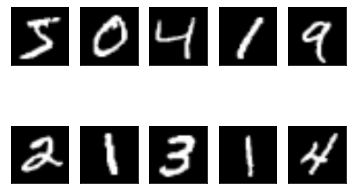

In [5]:
# 학습 데이터 시각화
fig = plt.figure()

for i in range(10):
    image,_ = dataset[i] 
    image = (image+1)/2 # 0과 1사이로 변경
    image = image.squeeze() # [1,64,64] -> [64,64]로 차원의 크기가 1인 것을 제거
    np_img = image.numpy() # numpy array로 변경
    
    subplot = fig.add_subplot(2, 5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(np_img, cmap = 'gray')

plt.show()

데이터 로더 정의

In [6]:
# dataloader
batch_size = 128 # 논문과 동일하게
workers = 2

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle = True, num_workers = workers)

In [7]:
# device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # gpu를 사용 여부에 대해 확인하는 코드
print(device)

cuda:0


In [8]:
#네트워크 하이퍼파라미터 설정
nc = 1 # number of channels in the training images (흑백)
nz = 100 # size of z latent vector (논문과 동일)

# 64x64 이미지.
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator 


In [9]:
#가중치 초기화 함수 정의
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
class Generator(nn.Module): # 해당 논문의 그림과는 feature map이 다르지만 feature map을 64로 설정했으므로 이를 따른다.
    # nz: length of the z input vector
    # ngf: size of the feature maps
    # nc: number of channels in the output image
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # z(또는 nz)을 input으로하여 TransposedConV를 거쳐, 이미지로 변환된다. 
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False ), # input channel, output channel, filter size, stride, padding --> 크기는 논문과 동일하게
            nn.BatchNorm2d(ngf * 8), # 배치 정규화
            nn.ReLU(True), # 생성자는 output 제외 모두 ReLU를 사용한다.
            # 크기 : (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False), # 이미지 크기는 2배로 늘리고, channel은 2배로 줄이고, stride는 논문과 동일하게.
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # 크기 : (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # 크기 : (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # 크기 : (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 크기 : (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [11]:
netG = Generator().to(device) # 생성자 객체 생성
netG.apply(weights_init) # generator 모델에 가중치 초기함수 적용

# 생성자 출력
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


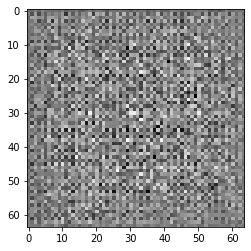

In [12]:
# 생성자 테스트
test_data=dataloader.dataset[0]
noise=torch.randn(1, nz, 1, 1, device=device) # [96,100,1,1] 크기의 노이즈

test_image=netG(noise)
test_image=test_image.squeeze().cpu().detach().numpy() # 이미지를 나타내지기 위해 tensor에서 넘파이로 데이터 타입 변경 [1,1,64,64] 
plt.imshow(test_image, cmap = 'gray')


In [13]:
class Discriminator(nn.Module): # 생성자와 반대로 진행하면 된다.
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential( 
            # input : (nc) x 64 x 64 의 이미지 - 여기서는 nc=1
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False), # 위에서 generator에 사용된 ConvTranspose2d와 다르게 Conv2d 사용 (in_channle, out_channel, kernel, stride, padding)
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False), # 이미지 크기는 2배로 줄이고, 채널의 크기는 2배로 늘린다.
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # 크기: (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [14]:
netD = Discriminator().to(device) # 판별자 객체 생성
netD.apply(weights_init) # 가중치 초기 함수 적용

# 판별자 출력
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [15]:
# 판별자 테스트
test_image=netG(noise)
netD(test_image)

tensor([[[[0.6243]]]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [16]:
# optimizer hyperparameters
criterion =nn.BCELoss() # binary cross entropy를 loss로 잡음 (fake, real)두가지 경우이기에 BCE적용
fixed_noise = torch.randn(64, nz, 1, 1, device=device) # 학습 과정을 보기 위한 노이즈.

real_label = 1. # 진짜 이미지 1로 label
fake_label = 0. # 가짜 이미지 0으로 label

# optimizer hyperparameters
learning_rate = 2e-4 # 논문과 동일
beta1 = 0.5 # Adam optimizer에 들어갈 hyperparameter, 논문과 동일

# optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

In [17]:
num_epochs = 5 # 더 늘리셔도 됩니다.

# 학습 과정 저장
img_list = []
G_losses = []
D_losses = []
iters = 0

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        ########################
        # (1) 판별자(D) 업데이트 : 식 log(D(x)) + log(1 - D(G(z))) 를 최대화 한다.
        ########################
        # 즉, 기존 이미지인 x를 진짜(1)로 판별하고
        # 생성 이미지인 G(z)를 가짜(0)으로 판별

        ## 진짜 이미지에 대한 학습

        netD.zero_grad() # train Discriminator 시작 -> 역전파 학습 전에 gradients를 zero 만들어줌
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0) # batch size.
        label = torch.full((b_size, ), real_label, dtype=torch.float, device=device)
        
        # 모든 실제 batch를 Discriminator에 삽입
        output = netD(real_cpu).view(-1)
        # 실제 batch에 loss를 계산
        errD_real = criterion(output, label) # label : (batch x 1)
        # Discriminator의 gradients를 backward로 계산
        errD_real.backward()
        D_x = output.mean().item() 

        ## 가짜 이미지에 대한 학습

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generator를 활용하여 fake image 생성
        fake = netG(noise)
        # fake label로 label을 다 채우기에 '0'으로 모두 입력
        label.fill_(fake_label) 
        # Discriminator를 활용하여 fake batch를 구별
        output = netD(fake.detach()).view(-1)
        # 모든 fake batch에 대해서 Discriminator에 대한 loss를 계산
        errD_fake = criterion(output, label)
        # 이 batch에 대한 gradient를 계산한다.(이전 gradient들 누적합)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # 진짜 이미지, 가짜 이미지에 대한 loss를 합한다 - 목표 : argmax errD
        errD = errD_real + errD_fake # fake와 real batch에 대한 Discriminator error의 합을 구함
        # 판별자(D) 업데이트
        optimizerD.step()

        ########################
        # (2) 생성자(G) 업데이트 : log(D(G(z)))를 최대화한다.
        ########################

        netG.zero_grad()
        label.fill_(real_label) # fake label은 Generator에서 real이다
        # D만 업데이트 된 상태이므로 다시 판별자(D)에 가짜 이미지를 통과.
        output = netD(fake).view(-1)
        # Generator의 loss를 계산함
        errG = criterion(output, label)
        # Generator의 gradeint 계산
        errG.backward()
        D_G_z2 = output.mean().item()
        # 생성자(G) 업데이트
        optimizerG.step()

        # 학습 경과 출력
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            % (epoch, num_epochs, i, len(dataloader),
                errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            
        # loss history 저장
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # noise가 고정되어있을 때 생성자(G)가 생성하는 image history 저장
        # 더 자주 이미지를 저장하고 싶은 경우 아래 코드 수정(e.g., 500 -> 200)
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        

[0/5][0/469]	Loss_D: 2.0597	Loss_G: 3.0123	D(x): 0.3370	D(G(z)): 0.4880 / 0.0714
[0/5][50/469]	Loss_D: 0.0004	Loss_G: 34.5654	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][100/469]	Loss_D: 0.0007	Loss_G: 41.2827	D(x): 0.9993	D(G(z)): 0.0000 / 0.0000
[0/5][150/469]	Loss_D: 0.0000	Loss_G: 41.2278	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][200/469]	Loss_D: 0.0001	Loss_G: 41.1142	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][250/469]	Loss_D: 0.0001	Loss_G: 41.0890	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][300/469]	Loss_D: 0.0001	Loss_G: 41.0351	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][350/469]	Loss_D: 0.0001	Loss_G: 41.0710	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][400/469]	Loss_D: 0.0000	Loss_G: 41.0174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][450/469]	Loss_D: 0.0000	Loss_G: 40.9833	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][0/469]	Loss_D: 0.0000	Loss_G: 40.9799	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1/5][50/469]	Loss_D: 0.0000	Loss_G: 41.0017	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000

## Loss에 대한 설명을 해주세요.
- Loss_D : d_real_loss + d_fake_loss.
- Loss_G : D(fake_image) 의 real_loss
- D(x) : 실제 이미지에 대한 D 
- D(G(z)) : 생성된 이미지에 대한 D


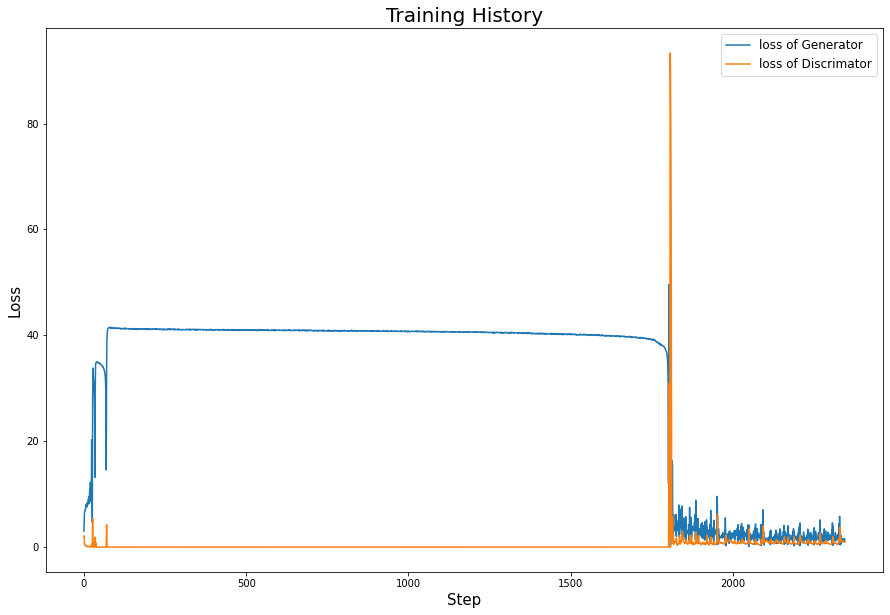

In [18]:
plt.figure(figsize=(15,10))
plt.title('Training History', fontsize=20)
plt.plot(G_losses, label='loss of Generator')
plt.plot(D_losses, label='loss of Discrimator')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('Step', fontsize=15)
plt.legend(fontsize=12)

In [19]:
import numpy as np
import matplotlib.animation as animation
from IPython.display import HTML

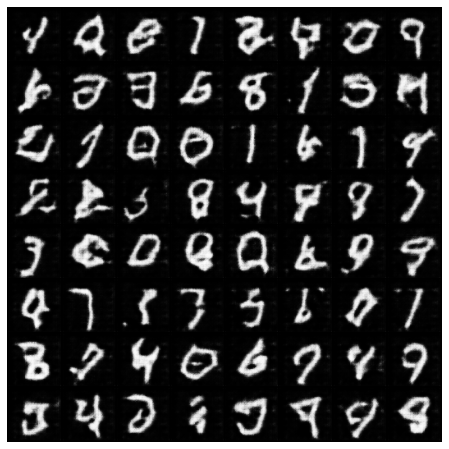

In [20]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

channel이 1개인 dataset이기에, 빠른 시간 안에 높은 정확도를 보이며 학습이 이루어졌다. 하지만 channel이 3인 dataset에서는 학습 시간이 더 길어질거라 예상되고 정확도도 낮을 것 같다.